# Chapter 4 Lab - Classifaction Models

### In this lab we will analyse stock market data in order to produce a qualitative prediction for whether the share price of the S&P 500 index will increase or decrease on a given day.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from patsy import dmatrices
import statsmodels.discrete.discrete_model as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
from statsmodels.graphics.regressionplots import *
from sklearn import datasets, linear_model
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import preprocessing

## 1. The Stock Market Data Set

In [4]:
Smarket = pd.read_csv('Smarket.csv', header = 0)
Smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [9]:
print("Columns in data set:\n", Smarket.columns)
print("The data types in each column:\n", Smarket.dtypes)
print("The shape of the data frame:\n", Smarket.shape)

Columns in data set:
 Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')
The data types in each column:
 Year           int64
Lag1         float64
Lag2         float64
Lag3         float64
Lag4         float64
Lag5         float64
Volume       float64
Today        float64
Direction     object
dtype: object
The shape of the data frame:
 (1250, 9)


In [11]:
Smarket.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000
mean,2003.016000,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138
std,1.409018,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334
min,2001.000000,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000
25%,2002.000000,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500
50%,2003.000000,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500
75%,2004.000000,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750
max,2005.000000,5.733000,5.733000,5.733000,5.733000,5.73300,3.152470,5.733000


### The stock market data set contains 1250 entries, corresponding to days ranging from the beginning of 2001 to the end of 2005. Each entry contains the percentage returns for the current day (variable 'Today'), as well as those for the previous 5 days (variables 'Lag1' through 'Lag5'). Additionally, the number of traded shares, in billions, for the current day are recorded in the variable 'Volume'. Finally, each entry contains the variable 'Direction', which shows whether the market was Up or Down on the respective day.

In [12]:
# it makes sense to consider the correlations between different variables in the data
Smarket.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


### We see that the correlations between the percentage returns for the various recorded days in each entry have little (close to zero) correlation between one another. This is to be expected, i.e., today's returns depend little on the returns from the previous 5 days. However, there seems to be strong correlation between the 'Year' and 'Volume' variables. We should plot these two features against one another to understand this better.

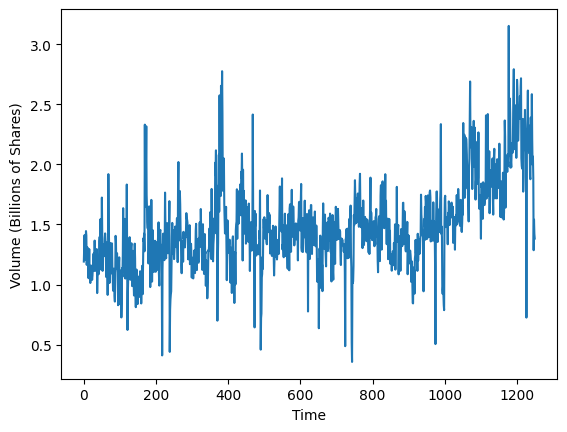

In [14]:
plt.plot(Smarket.iloc[:, 6])
plt.ylabel("Volume (Billions of Shares)")
plt.xlabel("Time")
plt.show()

### There seems to be an increase in the number of trades per day from 2001 to 2005.

## 2. Logistic Regression

In [19]:
# we create design matrices for the formula we want to fit
y, X = dmatrices('Direction~Lag1+Lag2+Lag3+Lag4+Lag5+Volume', Smarket, return_type='dataframe')
print(y)

      Direction[Down]  Direction[Up]
0                 0.0            1.0
1                 0.0            1.0
2                 1.0            0.0
3                 0.0            1.0
4                 0.0            1.0
...               ...            ...
1245              0.0            1.0
1246              1.0            0.0
1247              0.0            1.0
1248              1.0            0.0
1249              1.0            0.0

[1250 rows x 2 columns]


In [20]:
# We take the second column of the response matrix above, since we are more interested when the stock price will increase
logit = sm.Logit(y.iloc[:, 1], X)
fit = logit.fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:          Direction[Up]   No. Observations:                 1250
Model:                          Logit   Df Residuals:                     1243
Method:                           MLE   Df Model:                            6
Date:                Wed, 07 Sep 2022   Pseudo R-squ.:                0.002074
Time:                        15:58:44   Log-Likelihood:                -863.79
converged:                       True   LL-Null:                       -865.59
Covariance Type:            nonrobust   LLR p-value:                    0.7319
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1260      0.241     -0.523      0.601      -0.598       0.346
Lag1          -0.0731      0.

### We see that the $p$-values for the fit are quite large, with the lowest one being $\sim 0.145$ for the 'Lag1' variable. This is still relatively large, meaning that there is likely little association between the percentage change in price yesterday, and whether the price will increase/decrease today.

In [22]:
# we can also print just the fitted parameters
print(fit.params)

Intercept   -0.126000
Lag1        -0.073074
Lag2        -0.042301
Lag3         0.011085
Lag4         0.009359
Lag5         0.010313
Volume       0.135441
dtype: float64


In [23]:
# consider the predictions of our model on the first ten training inputs
print(fit.predict()[:10])

[0.50708413 0.48146788 0.48113883 0.51522236 0.51078116 0.50695646
 0.49265087 0.50922916 0.51761353 0.48883778]


In [36]:
# these are given as probabilities of the stock direction being Up
# hence, we shall convert these to class labels, after choosing a suitable threshold
threshold = 0.5
predict_label = pd.DataFrame(np.zeros(shape=(Smarket.shape[0], 1)), columns=['prediction label'])
predict_label.iloc[fit.predict() > threshold] = 'Up'
predict_label.iloc[fit.predict() <= threshold] = 'Down'
print("Model predictions:\n", predict_label.head())
print("Data set values:\n", Smarket['Direction'][:5])

Model predictions:
   prediction label
0               Up
1             Down
2             Down
3               Up
4               Up
Data set values:
 0      Up
1      Up
2    Down
3      Up
4      Up
Name: Direction, dtype: object


### As we can see above, the model isn't very good, as is to be expected from the observed large $p$-values. To further evaluate the model, we construct a confusion matrix.

In [44]:
conf_matrix = confusion_matrix(Smarket['Direction'], predict_label.iloc[:, 0])
print("True negatives (Down predicted as Down):", conf_matrix[0, 0])
print("False negatives (Down predicted as Up):", conf_matrix[0, 1])
print("True positives (Up predicted as Up):", conf_matrix[1, 1])
print("False positives (Up predicted as Down):", conf_matrix[1, 0])
print("\nThe model predicted the correct movement of the market " + str(conf_matrix.trace() / conf_matrix.sum() * 100) + "% of the time.")


True negatives (Down predicted as Down): 145
False negatives (Down predicted as Up): 457
True positives (Up predicted as Up): 507
False positives (Up predicted as Down): 141

The model predicted the correct movement of the market 52.16% of the time.


### It seems that the logistic regression model is slightly better than random guessing. However, this is misleading since we have both trained and evaulated the model on the same data sets. A better approach is to split the overall data set into training and validation subsets. Specifically, we will train the model on data from before 2005, and assess its predictive power on the data from 2005.

In [45]:
Smarket_2005 = Smarket.query('Year >= 2005')
Smarket_train = Smarket.query('Year < 2005')

In [46]:
y_train, X_train = dmatrices('Direction~Lag1+Lag2+Lag3+Lag4+Lag5+Volume', Smarket_train, return_type='dataframe')
y_test, X_test = dmatrices('Direction~Lag1+Lag2+Lag3+Lag4+Lag5+Volume', Smarket_2005, return_type='dataframe')

In [47]:
# fit the logistic model
logit = sm.Logit(y_train.iloc[:, 1], X_train)
fit = logit.fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.691936
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:          Direction[Up]   No. Observations:                  998
Model:                          Logit   Df Residuals:                      991
Method:                           MLE   Df Model:                            6
Date:                Wed, 07 Sep 2022   Pseudo R-squ.:                0.001562
Time:                        16:30:06   Log-Likelihood:                -690.55
converged:                       True   LL-Null:                       -691.63
Covariance Type:            nonrobust   LLR p-value:                    0.9044
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1912      0.334      0.573      0.567      -0.463       0.845
Lag1          -0.0542      0.

In [50]:
# test the model on 2005 data
predictions = fit.predict(X_test)
prediction_labels = pd.DataFrame(np.zeros(shape = (Smarket_2005.shape[0], 1)), columns=['prediction label'])
threshold = 0.5
prediction_labels.iloc[predictions > threshold] = 'Up'
prediction_labels.iloc[predictions <= threshold] = 'Down'
conf_matrix = confusion_matrix(Smarket_2005['Direction'], prediction_labels.iloc[:, 0])
print("True negatives (Down predicted as Down):", conf_matrix[0, 0])
print("False negatives (Down predicted as Up):", conf_matrix[0, 1])
print("True positives (Up predicted as Up):", conf_matrix[1, 1])
print("False positives (Up predicted as Down):", conf_matrix[1, 0])
print("\nThe model predicted the correct movement of the market " + str(conf_matrix.trace() / conf_matrix.sum() * 100) + "% of the time.")

True negatives (Down predicted as Down): 77
False negatives (Down predicted as Up): 34
True positives (Up predicted as Up): 44
False positives (Up predicted as Down): 97

The model predicted the correct movement of the market 48.01587301587302% of the time.


### We in fact see that the predictive power of the logistic regression model is worse than simply random guessing. This was to be expected from the large $p$-values we observed. However, the quality of the model may have also been influenced by the addition of variables with low predictive power, i.e., those with very large $p$-values, causing overfitting. Hence, we consider a model with just the two variables with lowest $p$-values, i.e., 'Lag1' and 'Lag2'.

In [51]:
y_train, X_train = dmatrices('Direction~Lag1+Lag2', Smarket_train, return_type='dataframe')
y_test, X_test = dmatrices('Direction~Lag1+Lag2', Smarket_2005, return_type='dataframe')

# fit the logistic model
logit = sm.Logit(y_train.iloc[:, 1], X_train)
fit = logit.fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.692085
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:          Direction[Up]   No. Observations:                  998
Model:                          Logit   Df Residuals:                      995
Method:                           MLE   Df Model:                            2
Date:                Wed, 07 Sep 2022   Pseudo R-squ.:                0.001347
Time:                        16:40:34   Log-Likelihood:                -690.70
converged:                       True   LL-Null:                       -691.63
Covariance Type:            nonrobust   LLR p-value:                    0.3939
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0322      0.063      0.508      0.611      -0.092       0.156
Lag1          -0.0556      0.

In [55]:
# test the model on 2005 data
predictions = fit.predict(X_test)
prediction_labels = pd.DataFrame(np.zeros(shape = (Smarket_2005.shape[0], 1)), columns=['prediction label'])
threshold = 0.5
prediction_labels.iloc[predictions > threshold] = 'Up'
prediction_labels.iloc[predictions <= threshold] = 'Down'
conf_matrix = confusion_matrix(Smarket_2005['Direction'], prediction_labels.iloc[:, 0])
print("True negatives (Down predicted as Down):", conf_matrix[0, 0])
print("False negatives (Down predicted as Up):", conf_matrix[0, 1])
print("True positives (Up predicted as Up):", conf_matrix[1, 1])
print("False positives (Up predicted as Down):", conf_matrix[1, 0])
print("\nThe model predicted the correct movement of the market " + str(conf_matrix.trace() / conf_matrix.sum() * 100) + "% of the time.")
print("\nThe model predicts the market will be Up with a " + str(conf_matrix[1, 1] / (conf_matrix[:, 1].sum()) * 100) + "% success rate.")

True negatives (Down predicted as Down): 35
False negatives (Down predicted as Up): 76
True positives (Up predicted as Up): 106
False positives (Up predicted as Down): 35

The model predicted the correct movement of the market 55.952380952380956% of the time.

The model predicts the market will be Up with a 58.24175824175825% success rate.


### The reduction of the number of variables used in the logistic regression model has indeed led to an improvement in the predictive power. However, it is still not much better than random guessing, or, in fact, simply assuming the market will be Up every day. Nonetheless, note that on days when the market was indeed Up, the model has predicted this correctly about $\sim 58\%$ of the time. So, a trading strategy which implements the model might be to only buy when the prediction is that the market will be Up.

## 3. Linear Discriminant Analysis

In [59]:
sklearn_lda = LDA(n_components=1) # LDA object
lda = sklearn_lda.fit(X_train.iloc[:, 1:3], y_train.iloc[:, 1]) # fitting the model

In [67]:
# test the model on the 2005 data
X_test_labels = lda.predict(X_test.iloc[:, 1:3])
print("Predicted labels:\n", X_test_labels[:5])
X_test_prob = lda.predict_proba(X_test.iloc[:, 1:3]) # probabilities of each test sample corresponding to each class
print("Predicted probabilities:\n", X_test_prob[:5, :])

Predicted labels:
 [1. 1. 1. 1. 1.]
Predicted probabilities:
 [[0.49017925 0.50982075]
 [0.4792185  0.5207815 ]
 [0.46681848 0.53318152]
 [0.47400107 0.52599893]
 [0.49278766 0.50721234]]


In [70]:
# determine the accuracy of the LDA model
print("LDA model accuracy:", np.mean(y_test.iloc[:, 1] == X_test_labels) * 100, "%")

LDA model accuracy: 55.952380952380956 %


### Note that this is the same as the accuracy for the logisitic regression, which makes sense, as both are linear models.

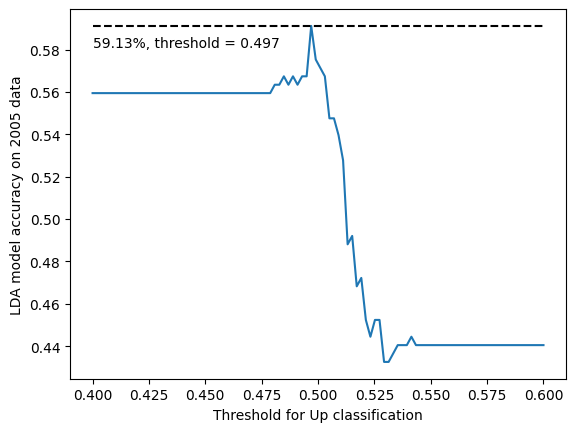

In [86]:
# we can try to find a threshold which maximises the accuracy of the model on the test data
thresholds = np.linspace(0.4, 0.6, num=100)
accuracies = []
for threshold in thresholds:
    accuracies.append(np.mean(y_test.iloc[:, 1] == (X_test_prob[:, 1] >= threshold)))
threshold_max_accuracy = thresholds[np.argmax(accuracies)]
plt.plot(thresholds, accuracies)
plt.plot(thresholds, [np.max(accuracies)] * len(thresholds), linestyle = 'dashed', color = 'black')
plt.text(thresholds[0], np.max(accuracies) - 0.01, str(round(np.max(accuracies), 4) * 100) + "%, threshold = " + str(round(threshold_max_accuracy, 4)))
plt.xlabel("Threshold for Up classification")
plt.ylabel("LDA model accuracy on 2005 data")
plt.show()

### There seems to be a slight benefit of using a threshold smaller than 0.5, but the improvement in accuracy is miniscule.

## 4. Quadratic Determinant Analysis

In [94]:
sklearn_qda = QDA(priors=None, store_covariance=True) # QDA object
qda = sklearn_qda.fit(X_train.iloc[:, 1:3], y_train.iloc[:, 1]) # fitting the model

# test the model on the 2005 data
X_test_labels = qda.predict(X_test.iloc[:, 1:3])
print("Predicted labels:\n", X_test_labels[:5])
X_test_prob = qda.predict_proba(X_test.iloc[:, 1:3]) # probabilities of each test sample corresponding to each class
print("Predicted probabilities:\n", X_test_prob[:5, :])

# determine the accuracy of the QDA model
print("QDA model accuracy:", np.mean(y_test.iloc[:, 1] == X_test_labels) * 100, "%")

Predicted labels:
 [1. 1. 1. 1. 1.]
Predicted probabilities:
 [[0.48732434 0.51267566]
 [0.47590106 0.52409894]
 [0.46369106 0.53630894]
 [0.4739253  0.5260747 ]
 [0.49034262 0.50965738]]
QDA model accuracy: 59.92063492063492 %


### The QDA model seems to be better than the LDA one, suggesting that a quadratic relationship in the data is a better assumption than the linear ones used by LDA and logistic regression. We can also perform a similar test for the optimal threshold, as we did for LDA.

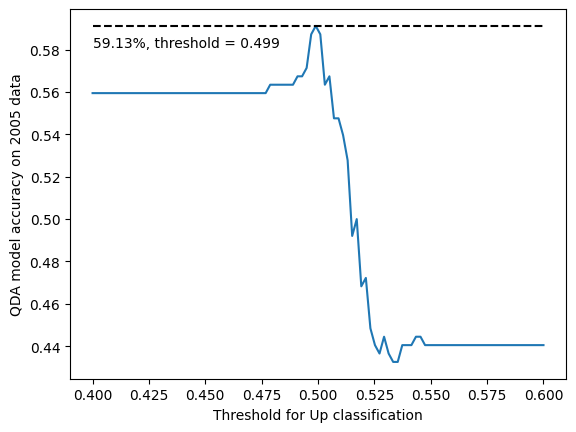

In [95]:
# we can try to find a threshold which maximises the accuracy of the model on the test data
thresholds = np.linspace(0.4, 0.6, num=100)
accuracies = []
for threshold in thresholds:
    accuracies.append(np.mean(y_test.iloc[:, 1] == (X_test_prob[:, 1] >= threshold)))
threshold_max_accuracy = thresholds[np.argmax(accuracies)]
plt.plot(thresholds, accuracies)
plt.plot(thresholds, [np.max(accuracies)] * len(thresholds), linestyle = 'dashed', color = 'black')
plt.text(thresholds[0], np.max(accuracies) - 0.01, str(round(np.max(accuracies), 4) * 100) + "%, threshold = " + str(round(threshold_max_accuracy, 4)))
plt.xlabel("Threshold for Up classification")
plt.ylabel("QDA model accuracy on 2005 data")
plt.show()

### For the QDA it seems that the best model is obtained using the default probability threshold of $0.5$.

## 5. Naive Bayes
### We now try fitting a naive Bayes model to the training data set.

In [96]:
NB_class = NB() # naive Bayes object
NB_class.fit(X_train.iloc[:, 1:3], y_train.iloc[:, 1])

X_test_labels = NB_class.predict(X_test.iloc[:, 1:3])
X_test_prob = NB_class.predict_proba(X_test.iloc[:, 1:3])

# determine the accuracy of the QDA model
print("Naive Bayes model accuracy:", np.mean(y_test.iloc[:, 1] == X_test_labels) * 100, "%")

Naive Bayes model accuracy: 59.523809523809526 %


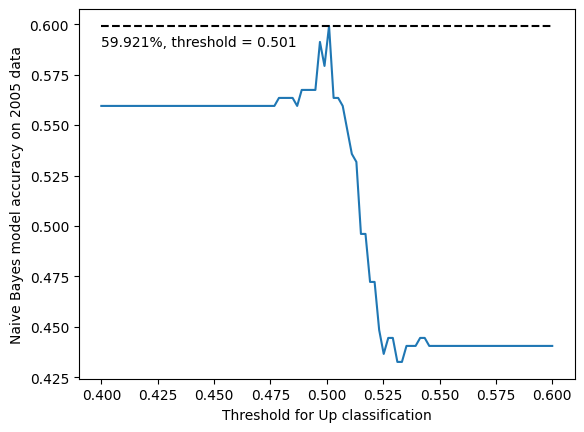

In [99]:
# we can try to find a threshold which maximises the accuracy of the model on the test data
thresholds = np.linspace(0.4, 0.6, num=100)
accuracies = []
for threshold in thresholds:
    accuracies.append(np.mean(y_test.iloc[:, 1] == (X_test_prob[:, 1] >= threshold)))
threshold_max_accuracy = thresholds[np.argmax(accuracies)]
plt.plot(thresholds, accuracies)
plt.plot(thresholds, [np.max(accuracies)] * len(thresholds), linestyle = 'dashed', color = 'black')
plt.text(thresholds[0], np.max(accuracies) - 0.01, str(round(np.max(accuracies), 5) * 100) + "%, threshold = " + str(round(threshold_max_accuracy, 4)))
plt.xlabel("Threshold for Up classification")
plt.ylabel("Naive Bayes model accuracy on 2005 data")
plt.show()

### The naive Bayes is just slightly worse than the QDA, but much better than the LDA.

## 6. K-Nearest Neighbours
### We consider fitting a K-nearest neighbours model to the data. We start with $K=1$, which will likely lead to an overfitted model, and then increase $K$ to find the optimal value.

In [115]:
no_neighbours = 3
neigh = KNN(n_neighbors=no_neighbours) # KNN object
KNN_fit = neigh.fit(X_train.iloc[:,1:3], y_train.iloc[:,1])

X_test_labels=KNN_fit.predict(X_test.iloc[:,1:3])
X_test_prob = KNN_fit.predict_proba(X_test.iloc[:,1:3]) 

print("K-nearest neighbours (K = " + str(no_neighbours) + ") model accuracy:", np.mean(y_test.iloc[:, 1] == X_test_labels) * 100, "%")

K-nearest neighbours (K = 3) model accuracy: 53.17460317460318 %


<function matplotlib.pyplot.show(close=None, block=None)>

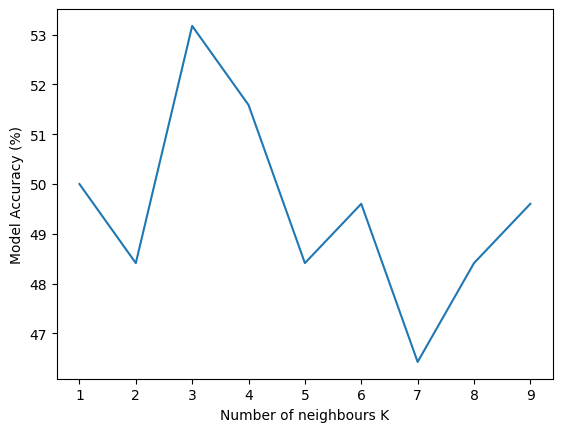

In [114]:
# find the optimal number of neighbours
K_values = np.arange(1, 10, 1, dtype=int)
accuracies = []
for K in K_values:

    neigh = KNN(n_neighbors=K) # KNN object
    KNN_fit = neigh.fit(X_train.iloc[:,1:3], y_train.iloc[:,1])

    X_test_labels=KNN_fit.predict(X_test.iloc[:,1:3])
    X_test_prob = KNN_fit.predict_proba(X_test.iloc[:,1:3]) 

    accuracies.append(np.mean(y_test.iloc[:, 1] == X_test_labels) * 100)

plt.plot(K_values, accuracies)
plt.xlabel("Number of neighbours K")
plt.ylabel("Model Accuracy (%)")
plt.show

### It seems like the best model is for $K=3$ neighbours, achieving an accuracy of $\sim 53\%$. This is still worse than the QDA, which seems to be the best model for this problem. Nonetheless, the $K$-nearest neighbours algorithm may still yield very good results in some cases. For example, let's now consider the Caravan data set.

In [116]:
Caravan = pd.read_csv("Caravan.csv", header=0)
Caravan.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,No
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,No
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,No


In [118]:
print(Caravan.shape)

(5822, 86)


### The Caravan data set consists of $5822$ entries, each one including $85$ predictors measuring demographic characteristics of individuals, and a response variable 'Purchase', indicating whether a caravan insurance policy has been purchased by the individual.
### Before we fit a $K$-nearest neighbours model to this data, we should standartise the predictors, since unstandartised data may have biased effects on the distance measurements performed by these types of models.

In [121]:
y_data = pd.DataFrame(np.zeros(shape=(Caravan.shape[0],1)), columns = ['label'])
y_data[Caravan['Purchase'] == 'Yes'] = 1
Caravan_predictors = Caravan.drop(labels='Purchase', axis=1)
print(Caravan_predictors.shape)

(5822, 85)


In [122]:
testing_data_size = 1000 # set size of test data set
X_test = Caravan_predictors.iloc[:testing_data_size]
Y_test = y_data.iloc[:testing_data_size]
X_train = Caravan_predictors.iloc[testing_data_size:]
Y_train = y_data.iloc[testing_data_size:]

X_train_scaled = preprocessing.scale(X_train) # scale the training data
scaler = preprocessing.StandardScaler().fit(X_train) # find the scaling used for the training data
X_test_scaled = scaler.transform(X_test) # apply the same scaling to the test data set

In [126]:
# train the K-nearest neighbours model
no_neighbours = 1
neigh = KNN(n_neighbors= no_neighbours)
KNN_fit = neigh.fit(X_train_scaled, Y_train.iloc[:,0])

X_test_labels = KNN_fit.predict(X_test_scaled)
X_test_prob = KNN_fit.predict_proba(X_test_scaled) 

print("Error rate for K-nearest neighbours with K = " + str(no_neighbours) + " is " + str(np.mean(Y_test.iloc[:,0]!=X_test_labels) * 100) + "%.")

Error rate for K-nearest neighbours with K = 1 is 11.700000000000001%.


### This might seem like a low error rate, but note that we can achieve a lower error rate by always guessing that individuals will opt out of the caravan insurance policy.

In [128]:
print("Error rate if we always predict 'No' irrespective of the predictor values:")
print(np.mean(Y_test.iloc[:,0]!=0) * 100, "%")

Error rate if we always predict 'No' irrespective of the predictor values:
5.8999999999999995 %


### However, we can view the problem from another angle. Suppose that there is some inherent cost when trying to sell insurance to a given individual, i.e., setting up a meeting, etc. If these were set at random, then the success rate would be $\sim 6\%$, as seen above, which is quite low. A good statistic for this type of problem would be to see what fraction of the individuals which are predicted to purchase the insurance, actually do so, i.e., the model's precision.

In [134]:
print("The precision for the K-nearest neighbours model with K = " + str(no_neighbours) + " is:")
purchase_predictions = np.sum(X_test_labels)
true_purchases = 0
for index, prediction in enumerate(X_test_labels):
    if prediction == 1 and Y_test.iloc[index, 0] == 1:
        true_purchases += 1
print(true_purchases / purchase_predictions * 100, "%")

The precision for the K-nearest neighbours model with K = 1 is:
11.842105263157894 %


### This is clearly much better than random selection, and it gets better for larger K values.

In [137]:
K_values = np.arange(1, 7, 1, dtype=int)
for K in K_values:

    neigh = KNN(n_neighbors= K)
    KNN_fit = neigh.fit(X_train_scaled, Y_train.iloc[:,0])

    X_test_labels = KNN_fit.predict(X_test_scaled)
    X_test_prob = KNN_fit.predict_proba(X_test_scaled)

    print("The precision for the K-nearest neighbours model with K = " + str(K) + " is:")
    purchase_predictions = np.sum(X_test_labels)
    true_purchases = 0
    for index, prediction in enumerate(X_test_labels):
        if prediction == 1 and Y_test.iloc[index, 0] == 1:
            true_purchases += 1
    print(true_purchases / purchase_predictions * 100, "%,")
    print("which includes " + str(purchase_predictions) + " total predictions of insurance purchasing.\n")

The precision for the K-nearest neighbours model with K = 1 is:
11.842105263157894 %,
which includes 76.0 total predictions of insurance purchasing.

The precision for the K-nearest neighbours model with K = 2 is:
0.0 %,
which includes 9.0 total predictions of insurance purchasing.

The precision for the K-nearest neighbours model with K = 3 is:
22.22222222222222 %,
which includes 27.0 total predictions of insurance purchasing.

The precision for the K-nearest neighbours model with K = 4 is:
14.285714285714285 %,
which includes 7.0 total predictions of insurance purchasing.

The precision for the K-nearest neighbours model with K = 5 is:
23.076923076923077 %,
which includes 13.0 total predictions of insurance purchasing.

The precision for the K-nearest neighbours model with K = 6 is:
33.33333333333333 %,
which includes 3.0 total predictions of insurance purchasing.



### We see that for $K=3$ we get a high precision, as well as a good amount of purchase predictions, so that seems like the best model for this data set.